In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Dropout, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Load the dataset

In [2]:
gray_image_dir = "/kaggle/input/landscape-image-colorization/landscape Images/gray"
color_image_dir = "/kaggle/input/landscape-image-colorization/landscape Images/color"

In [3]:
img_size = 128
gray_images = []
color_images = []

for img_name in tqdm(os.listdir(gray_image_dir)):
    img_path = os.path.join(gray_image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    img = np.expand_dims(img, axis = -1) 
    gray_images.append(img)

for img_name in tqdm(os.listdir(color_image_dir)):
    img_path = os.path.join(color_image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    color_images.append(img)

100%|██████████| 7129/7129 [00:23<00:00, 297.34it/s]


In [4]:
gray_images[0].shape, color_images[0].shape

((128, 128, 1), (128, 128, 3))

## Convert into array

In [5]:
gray_images = np.array(gray_images)
color_images = np.array(color_images)

In [6]:
gray_images.shape, color_images.shape

((7129, 128, 128, 1), (7129, 128, 128, 3))

## Let's see some image

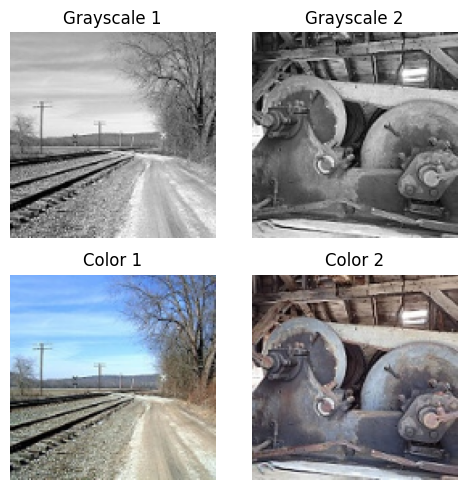

In [7]:
plt.figure(figsize = (5, 5))

for idx in range(2):
    plt.subplot(2, 2, idx * 1 + 1)
    plt.imshow(gray_images[idx], cmap = 'gray')
    plt.title(f"Grayscale {idx + 1}")
    plt.axis('off')
    
    plt.subplot(2, 2, idx * 1 + 3)
    plt.imshow(color_images[idx])
    plt.title(f"Color {idx + 1}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Splitting dataset

In [8]:
X_train_gray, X_test_gray, X_train_color, X_test_color = train_test_split(
    gray_images, color_images, test_size = 0.2, shuffle = False)

print("Training set - Gray images:", X_train_gray.shape)
print("Test set - Gray images:", X_test_gray.shape)
print("Training set - Color images:", X_train_color.shape)
print("Test set - Color images:", X_test_color.shape)

Training set - Gray images: (5703, 128, 128, 1)
Test set - Gray images: (1426, 128, 128, 1)
Training set - Color images: (5703, 128, 128, 3)
Test set - Color images: (1426, 128, 128, 3)


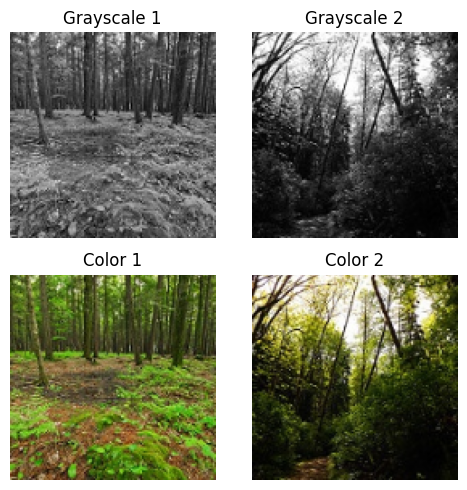

In [9]:
plt.figure(figsize = (5, 5))

for idx in range(2):
    plt.subplot(2, 2, idx * 1 + 1)
    plt.imshow(X_test_gray[idx], cmap = 'gray')
    plt.title(f"Grayscale {idx + 1}")
    plt.axis('off')
    
    plt.subplot(2, 2, idx * 1 + 3)
    plt.imshow(X_test_color[idx])
    plt.title(f"Color {idx + 1}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Create a network

In [10]:
autoencoder = Sequential([
    Input(shape = (img_size, img_size, 1)),
    Conv2D(32, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(128, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(256, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(32, kernel_size = 4, strides = 2, padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(3, kernel_size = 4, strides = 2, padding =  'same', activation = None),

    Conv2D(3, kernel_size = 3, strides = 1, padding = 'same', activation = 'sigmoid')
])

autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,381,911 (5.27 MB)

 Trainable params: 1,380,503 (5.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Compile the model

In [11]:
autoencoder.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001))

## Train the model

In [24]:
history = autoencoder.fit(X_train_gray, X_train_color, 
                          validation_data = (X_test_gray, X_test_color), 
                          epochs = 20, 
                          verbose = 1, 
                          batch_size = 32
                         )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0063 - val_loss: 0.0126
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0062 - val_loss: 0.0101
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0061 - val_loss: 0.0094
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0060 - val_loss: 0.0093
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0059 - val_loss: 0.0096
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058 - val_loss: 0.0104
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058 - val_loss: 0.0096
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058 - val_loss: 0.0107
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 

## Plot the performance graph

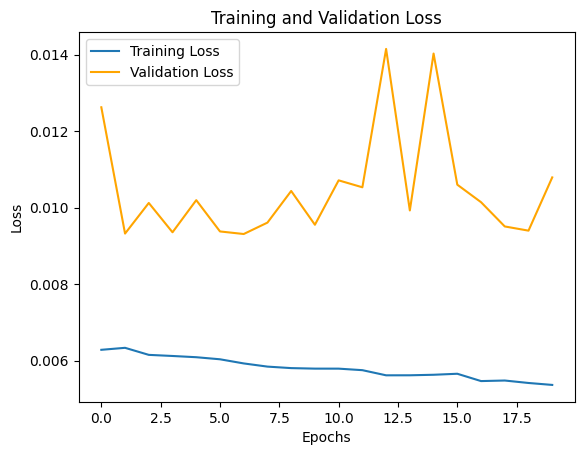

In [25]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict the dataset

In [26]:
decoded_images = autoencoder.predict(X_train_gray)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


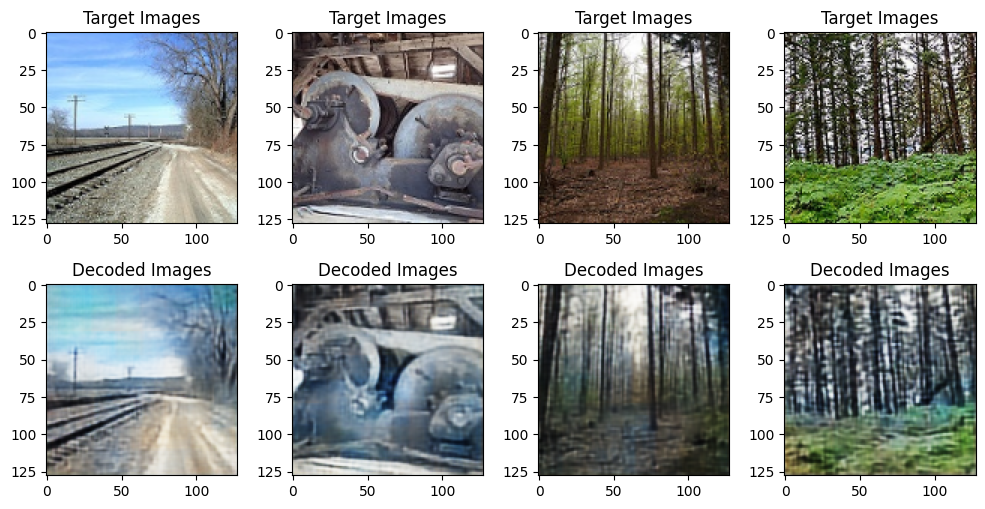

In [27]:
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train_color[i])
    plt.title('Target Images')
    
for i in range(4):
    plt.subplot(4, 4, i+5)
    plt.imshow(decoded_images[i])
    plt.title('Decoded Images')
    
plt.tight_layout()
plt.show()

In [28]:
# validation dataset
decoded_images = autoencoder.predict(X_test_gray)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


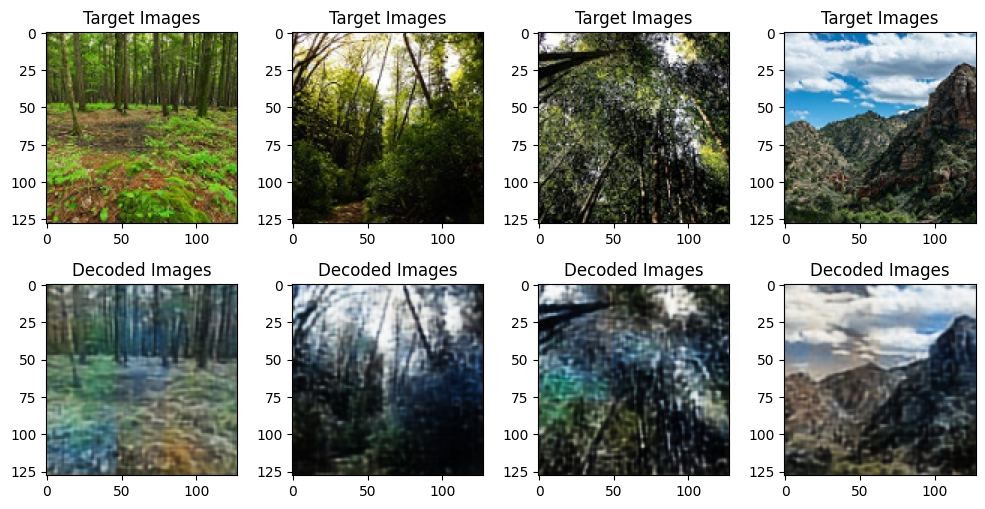

In [29]:
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_test_color[i])
    plt.title('Target Images')
    
for i in range(4):
    plt.subplot(4, 4, i+5)
    plt.imshow(decoded_images[i])
    plt.title('Decoded Images')
    
plt.tight_layout()
plt.show()